In [1]:
from copy import deepcopy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from Bio import Phylo, AlignIO

# Building a phylogenetic tree

In this second part of the tutorial, we will start from the multiple sequence alignment we previously generated, containing nucleotide sequences for the coding region of the HA influenza gene from H3N2 subtype viruses. We will use this alignment to reconstruct a phylogenetic tree that approximates the evolutionary history of these viruses.

We'll then discuss some common ways to visualize, manipulate and explore the tree.

## Building a tree with IQtree

To investigate evolutionary relationships between sequences in the alignment, we have to reconstruct the phylogenetic tree that approximates the evolutionary history of the viruses whose genomes we are analyzing. There are several commonly used tools for this, including

 - IQtree
 - RAxML
 - FastTree

We will use IQtree here, which can again be installed with `conda` via `conda install -c bioconda iqtree`. 

We can call IQtree (the program has looooots of options) via 
```bash
iqtree -s <input_alignment> -m GTR
```
The flag `-m GTR` tells IQtree to use a [generalized time-reversible substitution model](https://en.wikipedia.org/wiki/Substitution_model#Generalised_time_reversible).

After running the command (it should run for 3-4 minutes), you'll find a number of files in your directory. 

```txt
<input_alignment>.fasta.bionj
<input_alignment>.fasta.ckp.gz
<input_alignment>.fasta.iqtree
<input_alignment>.fasta.log
<input_alignment>.fasta.mldist
<input_alignment>.fasta.treefile
```

Some of these are log files, or checkpoints to restart the analysis. You can check out the `.iqtree` file to get information on the inferred parameters for the substitution model (transition rates, etc.).

The file we care most about is the file ending in `.treefile`. It contains the reconstructed tree in [`newick` format](https://en.wikipedia.org/wiki/Newick_format).

![newick format](assets/newick_format.png)




## visualizing the tree

There are many excellent tools for visualizing phylogenetic tree. A very convenient one is [Auspice](https://auspice.us/), which is a web-based tool that allows you to visualize and explore phylogenetic trees interactively.

After changing the file extension of the `.treefile` to `.nwk`, upload the file on Auspice and explore the tree.

Phylogenetic analysis often require integrating the phylogenetic tree with other information such as phenotype, geographic location, collection date... For the data at hand, you can also upload the metadata `csv` file generated previously, which lets you also color the tree by metadata.

![auspice](assets/auspice.png)

# Manipulating trees with Biopython

Once obtained your tree, you might want to perform different operations on it, such as calculating node properties, assigning a root...

Biopython provides [the `Phylo` library](https://biopython.org/wiki/Phylo) with a number of very useful basic function that allow you to work with phylogenetic trees.

We'll discuss a few common operations here:
- loading / drawing trees
- ladderizing trees
- rooting trees (better discussed in the next tutorial)
- preorder/postorder traversal

Let's load an visualize the tree. You can use the `read` and `draw` function for this.

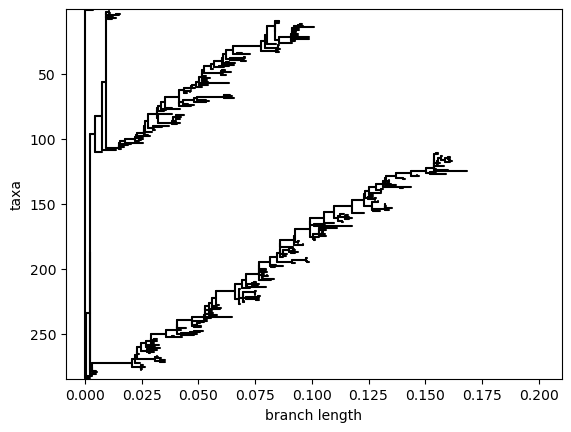

In [2]:
tree = Phylo.read("results/tree.nwk", "newick")

Phylo.draw(tree, label_func=lambda x: None)

### Ladderization

Note that whenver we have an internal node, there is no unique way to order the children of that node. Any flip between the order of the children will result in the same tree topology.

A conventional way to resolve this ambiguity is to "ladderize" the tree. This is a common operation in phylogenetics, and it is often used to make trees easier to read and interpret. "Ladderizing" consists in sorting the children of each node such that the child with the smallest number of terminal descendants is placed first (or last). Biopython conveniently implements the `ladderize` function for this.

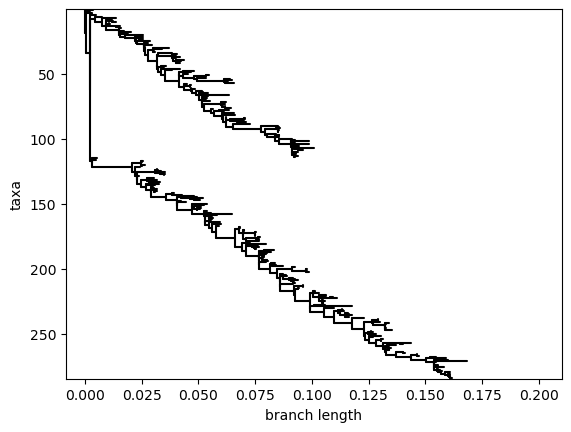

In [3]:
tree.ladderize()
Phylo.draw(tree, label_func=lambda x: None)

## Rooting the tree

Another important decision when it comes to analyzing phylogenetic trees is the placement of the root. This decides the direction of time along the branches.

There are several ways to root a tree. We will discuss them in more detail in the next section. For now, we will root the tree using the oldest sequence in the dataset as an outgroup.


In [4]:
metadata = pd.read_csv("results/h3n2_metadata.csv", parse_dates=["date"], index_col=0)
metadata.sort_values("date").head()

,description,date,country,len,ambiguous,collection_year
accession,,,,,,
CY034012.1,Influenza A virus (A/Hong Kong/1-6-MA21-2/1968...,1968-01-01,Hong Kong,1715,0,1968
CY033553.1,Influenza A virus (A/Hong Kong/1-11-MA21-3/196...,1968-01-01,Hong Kong,1719,0,1968
CY033017.1,Influenza A virus (A/Hong Kong/1-4/1968(H3N2))...,1968-01-01,Hong Kong,1720,0,1968
CY033988.1,Influenza A virus (A/Hong Kong/1-1-MA-12D/1968...,1968-01-01,Hong Kong,1719,0,1968
CY146809.1,Influenza A virus (A/Victoria/JY2/1968(H3N2)) ...,1968-01-01,Australia,1743,0,1968


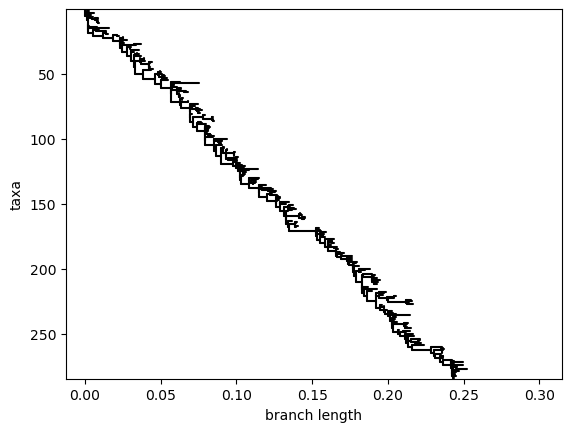

1

In [5]:
# we can use one of the original Hong-Kong sequences as an outgroup
outgroup = "CY034012.1"

tree.root_with_outgroup(outgroup)
tree.ladderize()
Phylo.draw(tree, label_func=lambda x: None)

# save rooted tree for later visualizations
Phylo.write(tree, "results/tree_rooted.nwk", "newick")

## Tree traversal

Unlike lists, trees are not linear data structures, but rather hierarchical data structures. Many of the algorithms that operate on trees require you to visit all nodes, but there is no single order in which to do this, and the order often matters.

There are several common ways to [traverse a tree](https://en.wikipedia.org/wiki/Tree_traversal):

 - **pre-order**: visit the parents before its children, starting at the root.
   This is often useful if the information needed at a node can be calculated from the information of its parent. (E.g. distance from the root).
 - **post-order**: visit children before its parent
   Useful if the information needed at a node can be calculated from the information of its children. (E.g. number of leaves below a node).
 - level or **breadth-first** traversal: root -> children of the root -> grand-children of the root -> ...

![tree traversal](assets/tree_traversal.png)
![level traversal](assets/level_traversal.png)

Pre-order and post-order traversal are at the heart of many efficient recursive algorithms.


### Simple example: calculate the number of leaves below each node. 

If we want to calculate the number of leaves below each internal node, we can use a post-order traversal. We can assign to each terminal node `n_leaves=1`, and for each internal node, we can sum the number of leaves of its children.

![n. leaves postorder](assets/n_leaves_postorder.png)


In [6]:
def calculate_n_leaves(tree):
    """Assign the number of leaves to each internal node"""
    T = deepcopy(tree)
    for node in T.find_clades(order="postorder"):
        if node.is_terminal():
            node.n_leaves = 1
        else:
            node.n_leaves = sum(child.n_leaves for child in node.clades)
    return T

T = calculate_n_leaves(tree)
print("total n. leaves:", T.root.n_leaves)

total n. leaves: 284


### Simple example: calculate the distance to the root.

If we want to calculate the distance of each internal node to the root, we can use a pre-order traversal. We can assign `distance=0` to the root, and for each other node we can set its `distance` equal to the distance of its parent plus the node branch length.

![distance to root pre-order](assets/root_distance_preorder.png)

In [7]:
def calculate_root_to_tip_distance(tree):
    T = deepcopy(tree)

    T.root.distance = 0
    for node in T.get_nonterminals(order="preorder"):
        for child in node.clades:
            child.distance = node.distance + child.branch_length
    
    return T

# calculate root-to-tip distances
T = calculate_root_to_tip_distance(tree)
rtt_distances = {l.name: l.distance for l in T.get_terminals()}
print("few root-to-tip distances:")
for k, v in list(rtt_distances.items())[:5]:
    print(f"node: {k}, distance: {v:.6f}")
    

few root-to-tip distances:
node: CY034012.1, distance: 0.000000
node: CY033988.1, distance: 0.002354
node: CY112257.1, distance: 0.005885
node: CY019899.1, distance: 0.003527
node: CY021837.1, distance: 0.004115


# Ancestral reconstruction

A very important problem in phylogenetics is to infer properties of "unobserved" internal nodes of the tree. For example, we might want to infer the nucleotide sequence of an ancestor of the sequences we are analyzing. Knowing the sequences of ancestors is extremely useful, as it allows for example to study the frequency and type of mutations observed. This is called "ancestral sequence reconstruction".

Other than sequence, one can also infer other properties of internal nodes, such as for example the geographic location. As a next example we will use the operations we discussed above to implement a simple algorithm for ancestral reconstruction.

## A simple example: Fitch parsimony

Fitch parsimony is a simple algorithm for inferring the state of internal nodes of a tree, given the state of all terminal nodes. 
It is a dynamic programming algorithm that is guaranteed to find the most parsimonious solution, i.e. the one that requires the least number of changes of state to explain the pattern observed on the leaves.
Note that this solution is not guaranteed to be unique, and there might be multiple equally parsimonious solutions. In this case the algorithm will return one of them.

### Algorithm description

The algorithm works with two three traversals.

In the first traversal nodes are visited post-order, starting from the leaves. In this traversal we assign to each node **a set of possible states**, given the set of possible states of its children.

- the state set of each terminal node is known 
- the state of internal node is derived from the states of its children. 
  - The state set of the node is the **intersection** of the state sets of its children, if this intesection is not empty.
  - If the intersection is empty, the state set of the node is the **union** of the state sets of its children. In this case we know that at least one change of state is required to explain the pattern observed in the leaves.

![fitch backward](assets/fitch_backw.png)

The second traversal is a pre-order traversal, where we **assign state to each node**.

- We assign to the root one of the states in its state set. If more than one state is possible, we can pick one at random.
- For each other node:
  - if the state set contains the state of its parent, we assign the same state to the node.
  - if the state set does not contain the state of its parent, we assign to the node one of the states in its state set, chosen at random. This corresponds to a change of state (yellow arrows).

![fitch forward](assets/fitch_fwd.png)

The final solution is guaranteed to have the minimal number of changes of state possible (yellow arrows).

### Infer geographic location of internal nodes

Let's use the functions we discussed above to implement the Fitch algorithm and infer the geographic location of the internal nodes of the tree we built previously.

In [8]:
leaves_states = metadata["country"].to_dict()
np.random.seed(0)

def fitch_parsimony(tree, leaves_states):

    # set state of the leaves
    for leaf in tree.get_terminals():
        leaf.state = set([leaves_states[leaf.name]])
    
    # postorder traversal
    for node in tree.get_nonterminals(order="postorder"):
        # get the states of the children
        children_states = [child.state for child in node.clades]
        # find the intersection of the states
        intersection = set.intersection(*children_states)
        if not intersection:
            # if there is no intersection, take the union
            node.state = set.union(*children_states)
        else:
            # if there is an intersection, take the intersection
            node.state = intersection

    print("Preorder traversal terminated")
    print("Possible root states:", tree.root.state)

    # set the state of the root by picking one of the possible states
    tree.root.state = np.random.choice(list(tree.root.state))
    print("Root state set to:", tree.root.state)
    tree.root.transition = ""

    # preorder traversal
    for node in tree.get_nonterminals(order="preorder"):
        for child in node.clades:
            # if the child state is not in the node state, set the node state to the child state
            if node.state in child.state:
                child.state = node.state
                child.transition = ""
            else:
                child.state = np.random.choice(list(child.state))
                child.transition = f"{node.state} -> {child.state}"
    
    print("Preorder traversal terminated\n")
            
fitch_parsimony(tree, leaves_states)

transitions = [n.transition for n in tree.find_clades() if n.transition]
print("total number of transitions:", len(transitions))
print("out of a total of ", len(list(tree.find_clades())), "nodes")
print("most common transitions:")
pd.Series(transitions, name="transitions").value_counts().head(10)


Preorder traversal terminated
Possible root states: {'Hong Kong'}
Root state set to: Hong Kong
Preorder traversal terminated

total number of transitions: 104
out of a total of  567 nodes
most common transitions:


transitions
USA -> Netherlands          9
USA -> China                9
Netherlands -> USA          8
USA -> Hong Kong            7
Netherlands -> France       4
USA -> Thailand             4
Hong Kong -> USA            3
Australia -> New Zealand    3
USA -> Australia            3
USA -> New Zealand          3
Name: count, dtype: int64

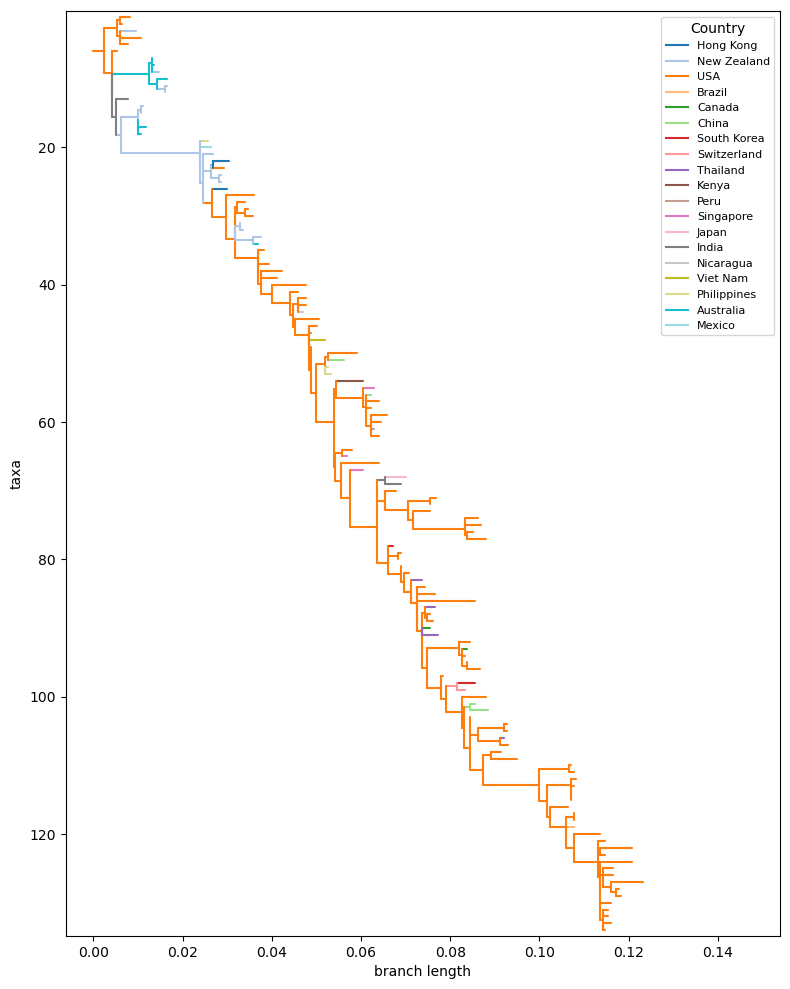

In [9]:

# restrict to recent part of the tree
recent = metadata["date"] > pd.Timestamp("2000-01-01")
recent_idxs = metadata[recent].index
recent_tree = tree.common_ancestor(recent_idxs)

# colormap for contries
recent_countries = metadata.loc[recent_idxs]["country"].unique()
cmap = plt.get_cmap("tab20", len(recent_countries))
country_colors = {country: mpl.colors.to_hex(cmap(i)) for i, country in enumerate(recent_countries)}


# set the color of the nodes based on the country
for node in recent_tree.find_clades(order="postorder"):
    if node.state in country_colors:
        node.color = country_colors[node.state]
    else:
        node.color = "gray"

fig, ax = plt.subplots(figsize=(8, 10))
# Phylo.draw(recent_tree, branch_labels=lambda n:n.transition, label_func=lambda n:'', axes=ax, do_show=False)
Phylo.draw(recent_tree, label_func=lambda n:'', axes=ax, do_show=False)
for country, color in country_colors.items():
    ax.plot([], [], color=color, label=country)
ax.legend(title="Country", loc="upper right", fontsize=8)
plt.tight_layout()
plt.show()


### Some caveats

This algorithm is very simple and has a number of limitations:

- this approach completely ignores branch lengths. For example, a change of state on a short branch should be less likely than a change of state on a long branch.
- the algorithm also ignores the fact that rates of transitions are not uniforms (e.g. countries have different sizes, and different sampling biases... Nucleotides are not equally likely to mutate into each other...).
- often there are many possible parsimonious solutions, and the algorithm only returns one.

This algorithm is appropriate only when changes of state are rare and unambiguous. When we need a more precise solution, it is advisable to use more sophisticated methods with a proper probabilistic model that takes these variables into account.

# Consistency check: alignment distance vs tree distance

When reconstructing a phylogenetic tree, the algorithm tries to maximize the likelihood of the tree given the alignment. This means that the distance between two sequences in the alignment should be closely related to the distance between the two sequences in the tree.

We can check that this is the case by calculating these two distances:
- sequence divergence can be calculated from the hamming distance in alignment
- distances of leaves on the tree can be calculated using the `distance` method of the tree object.

Look at the joint distribution of the two distances. What do you observe? Why is their relationship not linear?

In [10]:
from itertools import combinations


aln = AlignIO.read("results/h3n2_coding.aln.fa", "fasta")
ids = [rec.id for rec in aln]
A = np.array(aln)
aln_divergence = []
for i, j in combinations(range(len(ids)), 2):
    idxi = ids[i]
    idxj = ids[j]
    if idxi > idxj:
        idxi, idxj = idxj, idxi
    seqi = A[i]
    seqj = A[j]
    div = np.mean(seqi != seqj)
    aln_divergence.append({
        "id1": idxi,
        "id2": idxj,
        "aln_divergence": div,
    })
aln_divergence = pd.DataFrame(aln_divergence).set_index(["id1", "id2"])
aln_divergence

aln_divergence
id1        id2                       
CY013919.1 CY038959.1        0.012956
CY038663.1 CY038959.1        0.010012
CY013525.1 CY038959.1        0.013545
CY006115.1 CY038959.1        0.014723
CY038959.1 OP511830.1        0.072438
...                               ...
CY006691.1 CY020325.1        0.001767
           CY006707.1        0.002945
CY006699.1 CY020325.1        0.004711
           CY006707.1        0.004711
CY006707.1 CY020325.1        0.003534

[40186 rows x 1 columns]

In [11]:
# calculate tree distances
tree_distances = []
for i, j in combinations(tree.get_terminals(), 2):
    idxi = i.name
    idxj = j.name
    if idxi > idxj:
        idxi, idxj = idxj, idxi
    dist = tree.distance(i, j)
    tree_distances.append({
        "id1": idxi,
        "id2": idxj,
        "tree_distance": dist,
    })
tree_distances = pd.DataFrame(tree_distances).set_index(["id1", "id2"])
tree_distances

,,tree_distance
id1,id2,
CY033988.1,CY034012.1,0.002354
CY034012.1,CY112257.1,0.005885
CY019899.1,CY034012.1,0.003527
CY021837.1,CY034012.1,0.004115
CY034012.1,CY113045.1,0.005291
...,...,...
PP619459.1,PP904074.1,0.002954
PP685646.1,PP904074.1,0.001772
PP619459.1,PQ412865.1,0.002955


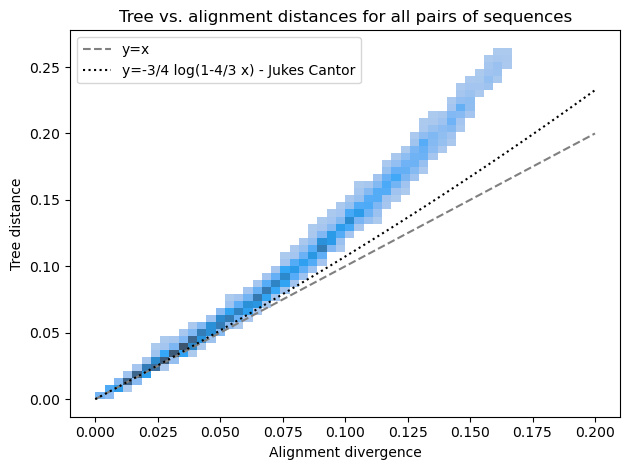

In [12]:
# merge the two dataframes
dist = aln_divergence.join(tree_distances)

# histogram of the joint distribution of the two distances
sns.histplot(data=dist, x="aln_divergence", y="tree_distance")
# plot diagonal
plt.plot([0, 0.2], [0, 0.2], color="gray", linestyle="--", label="y=x")
# plot Jukes-Cantor model
x = np.linspace(0, 0.2, 100)
y = - 3/4 * np.log(1 - 4/3 * x)
plt.plot(x, y, "k:", label="y=-3/4 log(1-4/3 x) - Jukes Cantor")
plt.xlabel("Alignment divergence")
plt.ylabel("Tree distance")
plt.title("Tree vs. alignment distances for all pairs of sequences")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()